# W to tau branching ratios

To estimate the branching ratio $W\rightarrow \tau\nu_{\tau}$, a template will be performed to the data collected in 2016 by CMS.  The basic idea is select on events consistent with $t\bar{t}$ production, form templates for the various decay modes and background processes, and then carry out a template fit to the data.  In general, a template fit can be thought of as an n-component mixture model such that,

$$
f(x) = \sum_{i} \alpha_{i}h_{i}(x),
$$

with the constraint that $\sum_{i}\alpha_{i} = 1$.  In our case the functional components are going to be histograms so that $h(x), f(x) \rightarrow h_{j}, h_{j}$.  The optimal (MLE) of the parameters $\alpha_{i}$ can be determined by minimizing the NLL give the data.  Because the dataset is large and the amount of data in each bin is large we will assume the data is distributed according to a Gaussian in each bin, i.e., the NLL will be the same as minimizing the $\chi^{2}$,

$$
\chi^{2} = \sum_{j} \frac{(y_{j} - f_{j})^{2}}{\sigma_{j}^{2}},
$$

where $y_{j}$ is the number of data events in bin $j$ and $\sigma_{j}^{2}$ corresponds to the variance.  The variance is the combination of the statistical error on the data ($\sigma_{j}^{2} = N_{j}$) and the statistical plus systematic uncertainty on the data model prediction(\textit{systematic uncertainties have not yet been considered for the data modelling, but will eventually be incorporated})

For this particular measurement there are some important additional considerations; primary among them is the fact that the mixture components $\alpha_{i}$ for the various decay components will be highly correlated.  This is because they will all have some dependencies on the underlying physical processes.  For example, one component that will be of interest will arise from the decay $t\bar{t}\rightarrow WbWb \rightarrow \mu\mu bb$, and another will arise from the decay $t\bar{t}\rightarrow WbWb \rightarrow \mu\tau_{\mu} bb$ (here $\tau_{\mu}$ indicates that the $\tau$ lepton subsequently decays to a muon).  The corresponding mixture amplitudes can be written,

$$
\alpha_{\mu\mu} = \frac{\epsilon_{\mu\mu}\beta_{\mu}^{2}}{\mathcal{A}},
$$
$$
\alpha_{\mu\mu_{\tau}} = \frac{2\epsilon_{\mu\tau}b_{\mu}\beta_{\mu}\beta_{\mu_{\tau}}}{\mathcal{A}}.
$$

This is the case for every mixture term associated with the signal decays.  For shorthand, I am writing the branching fraction of W to X as $\beta_{X}$ and the branching fraction of $\tau$ to X as $b_{X}$.  The $\epsilon$ term represents the combined efficiency and acceptance for that particular decay mode.  Also, there is the normalization factor $\mathcal{A}$ which is a sum over all signal processes.  (Technically, there is a factor of $\sigma_{signal}$ and $\mathcal{L}$ but these should cancel, I think).

In total we have 21 possible decay modes for double W production (as in the case of $t\bar{t}$) when we group together all hadronic final states and separate out the different $\tau$ decay modes.  Of these decay modes, there are four underlying branching fractions, 

$$
\boldsymbol{\beta} = \{\beta_{e}, \beta_{\mu}, \beta_{\tau}, \beta_{h}\},
$$

with a constraint that,

$$
\sum_{p}\beta_{p} = 1.
$$
Additionally there are three nuisance parameters for the decay of the $\tau$, 

$$
\mathbf{b} = \{b_{e}, b_{\mu}, b_{h}\}.
$$

These will be fixed to the PDG values and can at a later time be treated as nuisance parameters where we will marginalize over their uncertainties (which are small, ~0.1%).  The full pdf is thus:

$$
\boldsymbol{\alpha} = \{\epsilon_{\mu\mu}\beta_{\mu}^{2}, \epsilon_{ee}\beta_{\mu}^{2}\}
$$

In [1]:
# imports and configuration
%cd '/home/naodell/work/CMS/z_plus_jpsi'
%matplotlib notebook

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.stats import chi2, beta
import numdifftools as nd

import scripts.plot_tools as pt
import scripts.fit_helpers as fh

matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/CMS/z_plus_jpsi


Before running this step, the templates must be generated using scripts/template_maker.py.  This will provide template histograms as well as efficiencies (estimated from MC) for the various decay modes of the WW pair.

In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/baseline/'
beta_type  = 'pdg'
#selections = ['mumu']
selections = ['mumu', 'emu' , 'mutau', 'mu4j']
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  emu   = 'dilepton1_pt_asym', 
                  mutau = 'tau_mva', 
                  mu4j  = 'lepton1_pt'
                 )

fit_data = dict(selections=selections, n_selections=len(selections))
for selection in selections:
    fit_data[selection] = fh.get_template_data(input_dir, targets[selection], selection)

In [3]:
# initial values for tau branching fraction (b_e, b_mu, beta_h)
br_tau = [0.1783, 0.1741, 0.6476]

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h)
if beta_type == 'pdg':
    beta_init =[0.1065, 0.1059, 0.114, 0.676]
    var_beta  = [0.0017**2, 0.0015**2, 0.0022**2, 0.0031**2]
    mask      = [1, 1, 0, 1]
elif beta_type == 'lu':
    beta_init = [0.108, 0.108, 0.108, 0.676] # lepton universality (lep average)
    var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]
    mask      = [0, 0, 0, 1]

# first parameter is for the background component
bg_init, bg_var_init = [], []
for selection in fit_data['selections']:
    alpha_bg, alpha_var_bg = fit_data[selection]['bg_init']
    bg_init.append(alpha_bg)
    bg_var_init.append(alpha_var_bg)
    
p_init = dict(vals = np.array(bg_init + beta_init),
              var  = np.array(bg_var_init + var_beta),
              mask = np.array(len(selections)*[1, ] + mask)
             )

fit_data['p_init']       = p_init
fit_data['br_tau']       = br_tau
fit_data['bounds']       = len(selections)*[(0., 1.), ]+ 4*[(0, 1), ] #[(0.104, 0.109), (0.10, 0.12), (0, 1), (0.674, 679)]
fit_data['constraints']  = [
                            dict(type = 'eq', fun = fh.param_constraint_unitary),
                            #dict(type = 'eq', fun = fh.param_constraint_prior)
                           ]

In [4]:
# carry out fit
result = minimize(fh.mixture_cost,
                  fit_data['p_init']['vals'],
                  method      = 'SLSQP',
                  bounds      = fit_data['bounds'],
                  constraints = fit_data['constraints'],
                  args        = (fit_data, )
                 ) 
f_cost = partial(fh.mixture_cost, fit_data=fit_data)
sig, corr_matrix = fh.calculate_covariance(f_cost, result.x)

fit_data['results'] = result
fit_data['results_sig'] = sig
fit_data['results_corr'] = corr_matrix

In [5]:
# print fit results
np.set_printoptions(precision=4)
pd.set_option('precision', 4)

labels = [f'alpha_bg_{s}' for s in selections] + ['beta_e', 'beta_mu', 'beta_tau', 'beta_h']
result_table = dict(
                    index = labels, 
                    value = result.x,
                    error = sig
                   )
result_table = pd.DataFrame(result_table).set_index('index')
result_table[['value', 'error']]

,value,error
index,,
alpha_bg_mumu,0.0352,0.0029
alpha_bg_emu,0.0002,0.0001
alpha_bg_mutau,0.0030,0.0020
alpha_bg_mu4j,0.0444,0.0004
beta_e,0.1032,0.0012
beta_mu,0.1017,0.0011
beta_tau,0.0836,0.0024
beta_h,0.6640,0.0022


In [6]:
# print correlation matrix
corr_matrix = pd.DataFrame(corr_matrix,
                           columns=labels, 
                           index=labels
                          )
corr_matrix

,alpha_bg_mumu,alpha_bg_emu,alpha_bg_mutau,alpha_bg_mu4j,beta_e,beta_mu,beta_tau,beta_h
alpha_bg_mumu,1.0000e+00,1.8763e-06,2.5895e-03,1.6319e-03,-1.1029e-03,1.4476e-02,-4.7961e-02,-3.2897e-03
alpha_bg_emu,1.8763e-06,1.0000e+00,3.3145e-06,1.1630e-06,8.6367e-05,-6.3845e-05,-6.1637e-05,-3.4014e-06
alpha_bg_mutau,2.5895e-03,3.3145e-06,1.0000e+00,1.6100e-03,-9.5858e-04,-3.4423e-03,-5.3837e-02,2.3751e-03
alpha_bg_mu4j,1.6319e-03,1.1630e-06,1.6100e-03,1.0000e+00,-7.2634e-04,8.9884e-03,-2.9807e-02,-1.9351e-03
beta_e,-1.1029e-03,8.6367e-05,-9.5858e-04,-7.2634e-04,1.0000e+00,5.3956e-03,2.2906e-02,1.3919e-03
beta_mu,1.4476e-02,-6.3845e-05,-3.4423e-03,8.9884e-03,5.3956e-03,1.0000e+00,7.3463e-02,5.1074e-03
beta_tau,-4.7961e-02,-6.1637e-05,-5.3837e-02,-2.9807e-02,2.2906e-02,7.3463e-02,1.0000e+00,6.2214e-02
beta_h,-3.2897e-03,-3.4014e-06,2.3751e-03,-1.9351e-03,1.3919e-03,5.1074e-03,6.2214e-02,1.0000e+00


0.0318261807338
[ 0.1065  0.1059  0.114   0.676 ]
[  3.5216e-02   1.6868e-04   2.9781e-03   4.4429e-02   1.0318e-01
   1.0171e-01   8.3581e-02   6.6395e-01]
0


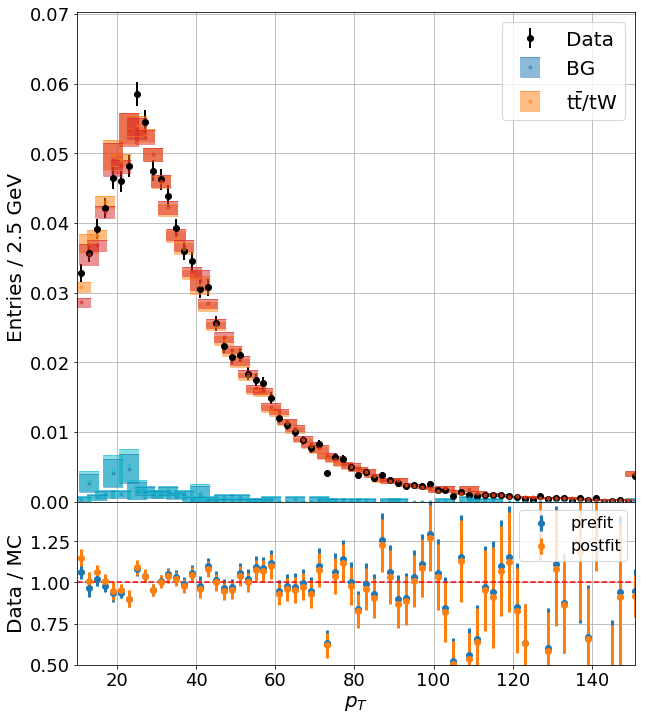

0.000206083236309
[ 0.1065  0.1059  0.114   0.676 ]
[  3.5216e-02   1.6868e-04   2.9781e-03   4.4429e-02   1.0318e-01
   1.0171e-01   8.3581e-02   6.6395e-01]
1


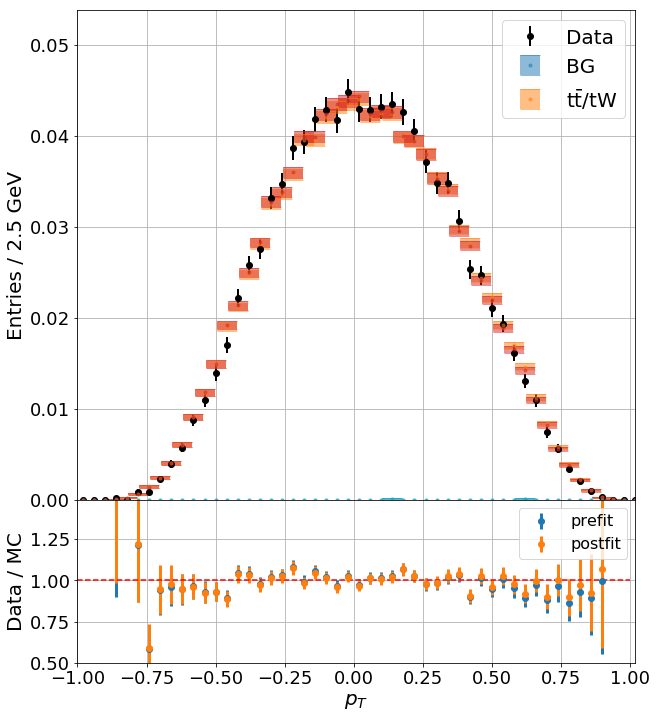

0.0116712474883
[ 0.1065  0.1059  0.114   0.676 ]
[  3.5216e-02   1.6868e-04   2.9781e-03   4.4429e-02   1.0318e-01
   1.0171e-01   8.3581e-02   6.6395e-01]
2


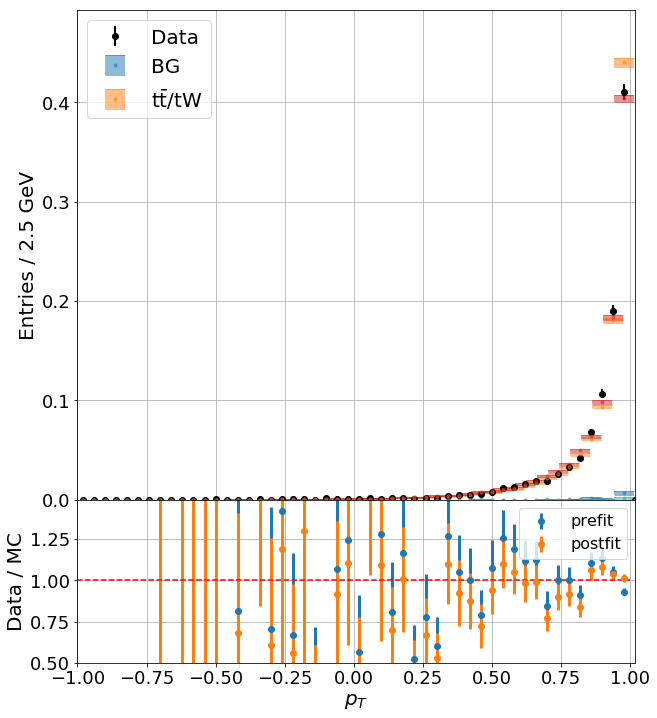

0.0447763936489
[ 0.1065  0.1059  0.114   0.676 ]
[  3.5216e-02   1.6868e-04   2.9781e-03   4.4429e-02   1.0318e-01
   1.0171e-01   8.3581e-02   6.6395e-01]
3


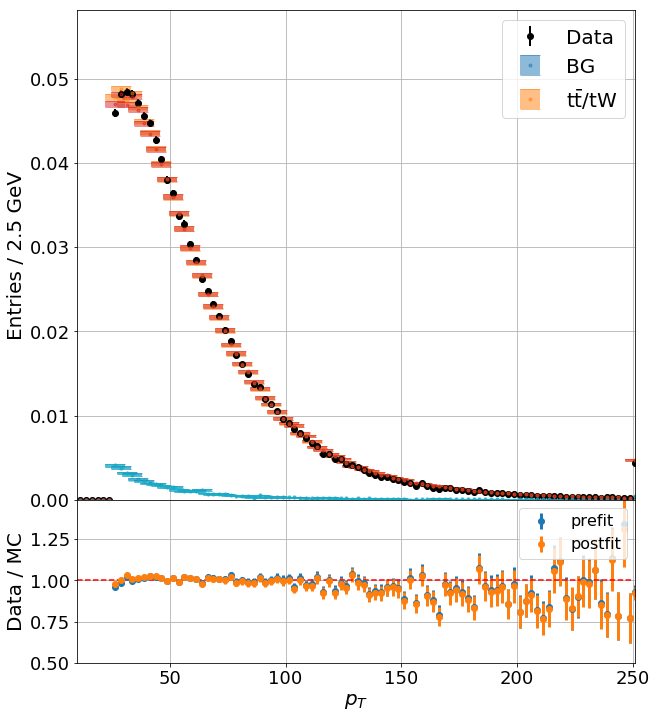

In [7]:
# make some plots
for selection in selections:
    fh.fit_plot(fit_data, selection, xlabel=r'$p_{T}$')